# Thresholding input point cloud as additional input channel

Following the test of converting the RGB-channels of the point cloud to greyscale and give this as an extra input to the model, the subsequent idea was to potentially either additionally or instead of the greyscale image feed-in a thresholded binary channel. In order to test that idea and find a good thresholding value, we will have to test the display of the thresholded point cloud.

## Imports

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt

## Functions

There is one thing to note for all the functions defined in this notebook. Namely, in several functions the functionality is based on a rigid structure of the point data array. Therefore, for the correct funtionality one should always make sure the input mostly referred to as 'point_data' comes in the following structure, accordin to column indices:
- 0: X-coordinate
- 1: Y-coordinate
- 2: Z-coordinate
- 3: Red color channel
- 4: Green color channel
- 5: Blue color channel
- 6: Labels 

In [81]:
def load_entire_sample(path_to_sample_folder):
    """Loading entire sample points into array from folder

    Args:
        path_to_sample_folder (str): string leading to sample folder containing block files

    Returns:
        np.ndarray: array of points from the entire sample [N, 6]
    """
    sample_points_list = []
    for i in range(len(os.listdir(path_to_sample_folder))):
        block_points = np.load(os.path.join(path_to_sample_folder, f'block_{i}.npy'))
        sample_points_list.extend(block_points)
    sample_points = np.array(sample_points_list)
    return sample_points

def pull_xyz_coords(point_data):
    """Pulling out X-, Y- and Z-coordinates separately from combined point data

    Args:
        point_data (np.ndarray): array of point data of an entire sample [N, 6]

    Returns:
        np.ndarray: X-coordinates, Y-coordinates, Z-coordinates
    """
    x_coords = point_data[:,0]
    y_coords = point_data[:,1]
    z_coords = point_data[:,2]
    return x_coords, y_coords, z_coords

def create_rgb_n_grey_normed(point_data):
    """Create normed rgb and grey channel array per point 

    Args:
        point_data (np.ndarray): array of point data of an entire sample [N, 6]

    Returns:
        np.ndarray: rgb_array - array holding the normed rgb values per point [N, 3]
        np.ndarray: grey_c - array holding the normed grey channel valules per point [N, 1]
    """
    red_c = point_data[:, 3]
    green_c = point_data[:, 4]
    blue_c = point_data[:, 5]
    # Creating grey channel via NTSC formula
    grey_c = np.array(0.2989 * red_c + 0.5870 * green_c + 0.1140 * blue_c)
    # Normalizing all channels
    red_c = (red_c - np.min(red_c)) / (np.max(red_c) - np.min(red_c))
    green_c = (green_c - np.min(green_c)) / (np.max(green_c) - np.min(green_c))
    blue_c = (blue_c - np.min(blue_c)) / (np.max(blue_c) - np.min(blue_c))
    grey_c = (grey_c - np.min(grey_c)) / (np.max(grey_c) - np.min(grey_c))
    # Creating RGB array
    rgb_array = np.ones((point_data.shape[0], 3))
    rgb_array[:,0] = red_c
    rgb_array[:,1] = green_c
    rgb_array[:,2] = blue_c
    return rgb_array, grey_c


def plot_points_3D(x_coords, y_coords, z_coords, rgb_array, point_size=1, topview=False, cmap=None):
    """Generic function to plot points

    Args:
        x_coords (np.ndarray): x-coordinates of points to be displayed [N, 1]
        y_coords (np.ndarray): y-coordinates of points to be displayed [N, 1]
        z_coords (np.ndarray): z-coordinates of points to be displayed [N, 1]
        rgb_array (np.ndarray): array holding normed rgb or greyscale values per point [N, 3] | [N, 1]
        point_size (int/np.ndarray, optional): int or array holding generic or per point size(s). Defaults to 1.
        topview (bool, optional): Boolean defining whether sample is viewed from the top. Defaults to False.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_coords,
               y_coords,
               z_coords, 
               c=rgb_array,
               s=point_size, 
               cmap=cmap)
    if topview:
        ax.view_init(elev=90, azim=-90)
    plt.show()

def create_binary_c(grey_c, thresh=0.5):
    """Create binarized color channel array from given grayscale array

    Args:
        grey_c (np.narray): array of N grayscale values [N, 1]
        thresh (float, optional): float between 0 and 1 setting the boundary for binarization

    Returns:
        np.ndarray: binarized color channel according to threshold given
    """
    return np.where(grey_c > thresh, 0, 1)
    
def return_binary_c_counts(binary_c):
    """Return and print the unique values and their counts

    Args:
        binary_c (np.ndarray): array of N greyscale values [N, 1]

    Returns:
        np.ndarray: uniques - array of all unique values in input array
        np.ndarray: counts - array of the unique value counts of the input array
    """
    uniques, unique_counts = np.unique(binary_c, return_counts=True)
    return uniques, unique_counts

def create_frac_points_binary_c(labels):
    """Creates binary color channel according to fracture labels

    Args:
        labels (np.ndarray): array of per point labels

    Returns:
        np.ndarray: frac_points_binary_c - color array holding marked and unmarked points color info
    """
    frac_points_binary_c = np.zeros(len(labels))
    for i in range(len(labels)):
        if labels[i] == 0.0:
            frac_points_binary_c[i] = 1
        else:
            frac_points_binary_c[i] = 0
    return frac_points_binary_c

## Setting of needed path variables

In [24]:
# Setting parameters for data loading
machine = 'laptop' #'laptop' / 'machine'
if machine == 'laptop':
    path_to_sample = '/Users/nk/Documents/GitHubRepos/Pointnet_Pointnet2_pytorch/data/samples/train/sample_0'
else:
    path_to_sample = 'will be inserted'

# Data Loading

In [25]:
sample_data = load_entire_sample(path_to_sample)
sample_points, sample_labels = sample_data[:,0:6], sample_data[:,6]

# Conversion to greyscale and display

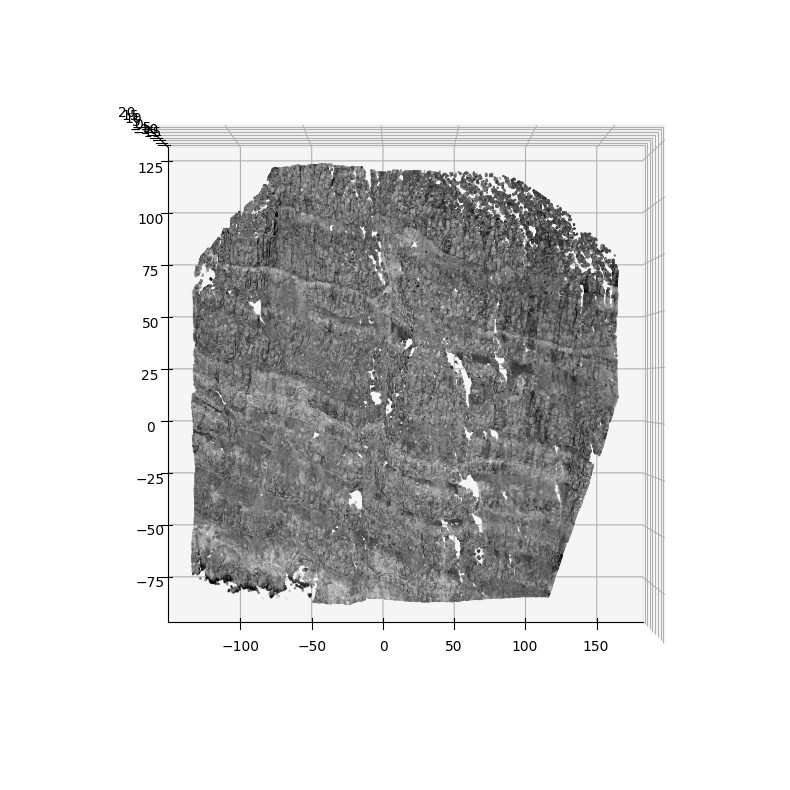

In [36]:
# Preparing location and color data for plotting
sample_rgb_array, sample_grey_c = create_rgb_n_grey_normed(sample_points)
sample_x, sample_y, sample_z = pull_xyz_coords(sample_points)

# Negating Y-coordinate to flip display for natural perspective
plot_points_3D(sample_x, 
               -sample_y, 
               sample_z, 
               sample_grey_c, 
               point_size=0.25,
               topview=True, 
               cmap='gray')

Even after playing around with the point size to get a more refined or detailed view of the scatterplot, the general structure of the fractures can clearly be seen in the greyscale image, but it does not feel intuitive, that these could be captured well by just thresholding the grey channel. Therefore, below we will investigate manually how different thresholds would impact the display and hence also what the model 'sees'.

# Thresholding

Pleasse set a desired threshold between 0 and 1 for the normed greyscale values below to determine the binarized color channel.

In [83]:
# Setting thresholding value for normed grey values
thresh = 0.6

# Displaying according to tresh binarized point cloud
binary_c = create_binary_c(sample_grey_c, thresh=thresh)

# Display of thresholded binary PC

In order to evaluate the thresholding the point cloud with the binarized color channel will be displayed below.

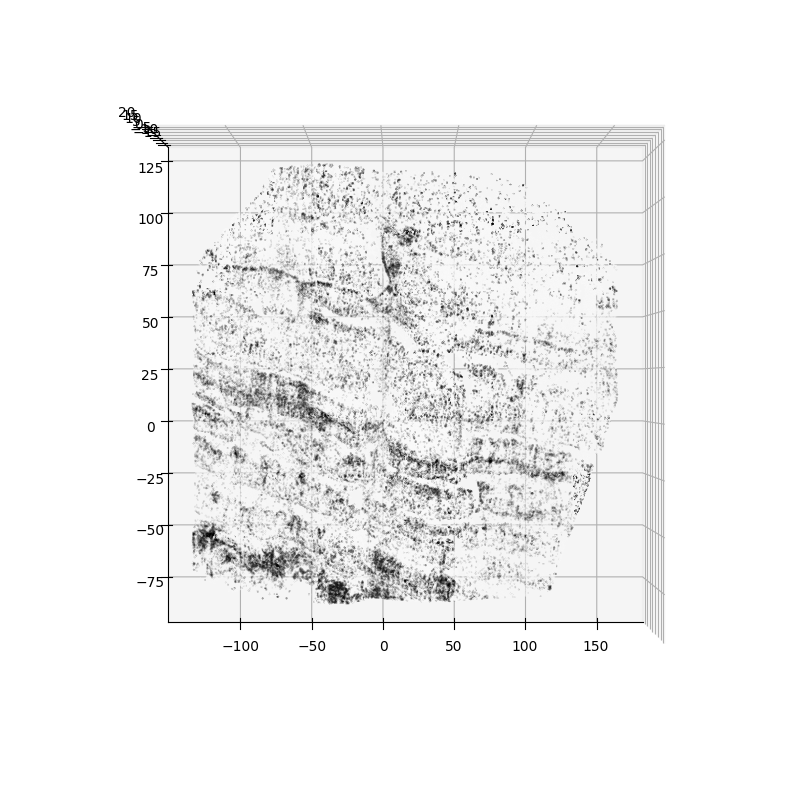

In [84]:
plot_points_3D(sample_x, 
               -sample_y, 
               sample_z, 
               binary_c, 
               point_size=0.01,
               topview=True, 
               cmap='gray')

# Results for binarized color channel

To just get a quick numerical overview of how the thresholding affected the display, below the unique values and their counts are printed.

In [85]:
uniques, counts = return_binary_c_counts(binary_c)

print(f'The binary channel contains {len(uniques)} unique values.')
if len(uniques < 5):
    print(f'The unique values are: {uniques}')
print(f'With a threshold of {thresh}, there are {counts[0]} points displayed in black and {counts[1]} points displayed in white.')

The binary channel contains 2 unique values.
The unique values are: [0 1]
With a threshold of 0.6, there are 100617 points displayed in black and 585463 points displayed in white.


# Display of fracture points

As a good measure, below only the points labelled as fracture points are displayed.

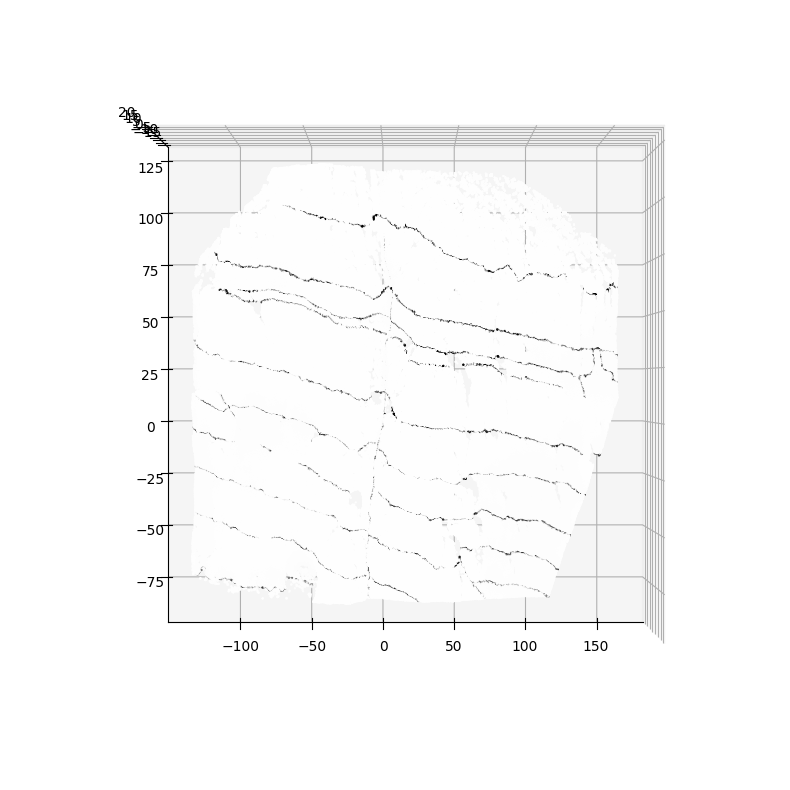

In [75]:
frac_points_binary_c = create_frac_points_binary_c(sample_labels)
plot_points_3D(sample_x, 
               -sample_y, 
               sample_z, 
               frac_points_binary_c, 
               point_size=0.5,
               topview=True, 
               cmap='gray')

# Display of thresholded point cloud alongside fractures

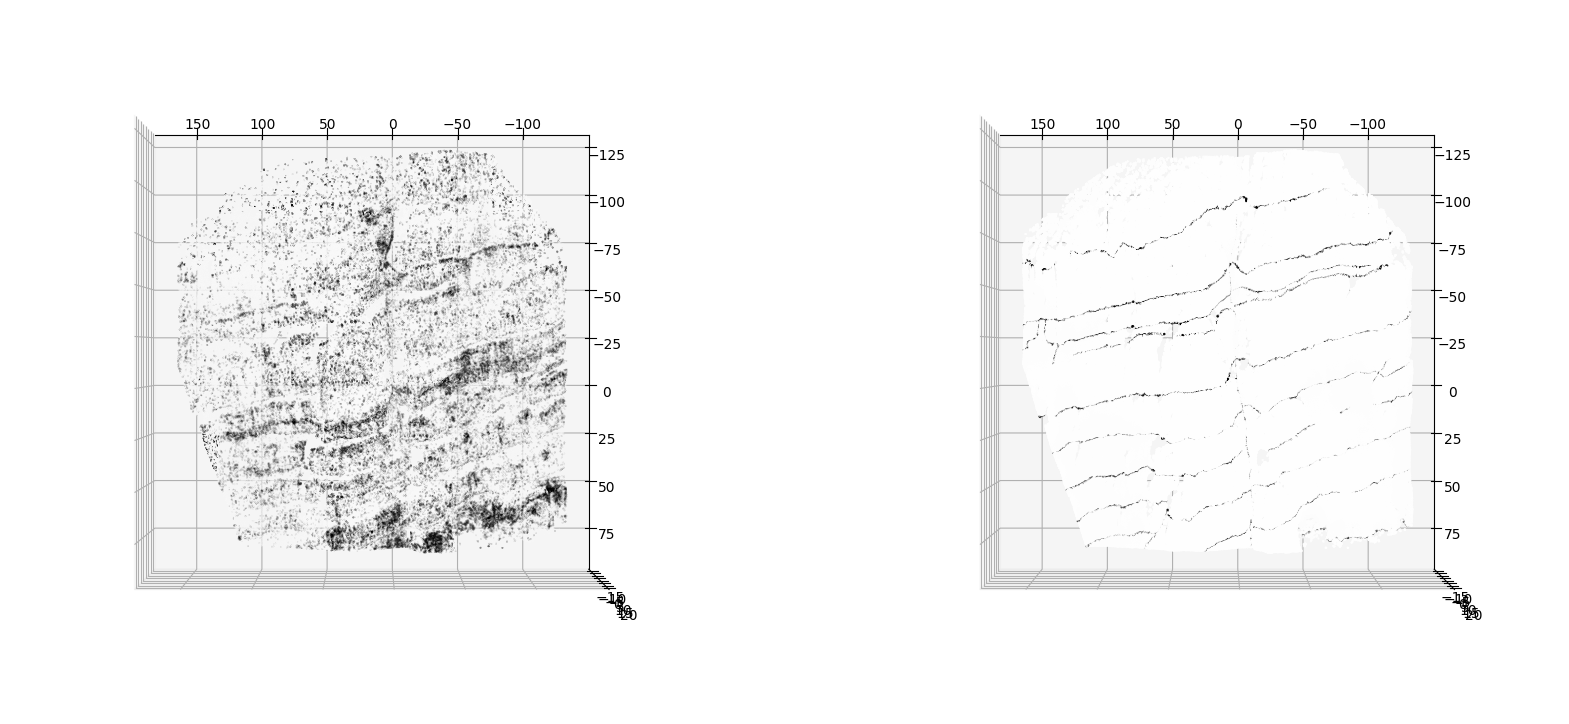

In [90]:
fig = plt.figure(figsize=(20, 10))
# Subplot 1: binarized point cloud
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(sample_x, 
            sample_y, 
            sample_z, 
            c=binary_c, 
            s=0.01,
            cmap='gray')
ax1.view_init(elev=90, azim=90)
# Subplot 2: Fracture Points
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(sample_x, 
            sample_y, 
            sample_z, 
            c=frac_points_binary_c, 
            s=0.5,
            cmap='gray')
ax2.view_init(elev=90, azim=90)
plt.show()

For now, because it seems to capture the rough fractures either as dark or light lines within the binarized point cloud, we will try and feed in a binarized version with a threshold of 0.6 of the point cloud on another channel, as I can believe the network learns better from the stark contrast change in the binarized channel.